In [ ]:
# Importation des librairies de base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import norm

import wrds


In [46]:
# Connexion à la base de données WRDS
db = wrds.Connection(wrds_username='lilas_bertot')

# Changer le nom après wrds_username pour te connecter, 
# entrer le nom d'utilisateur puis ton mot de passe dans la barre du haut, 
# puis "y" pour ne pas avoir à te reconnecter à chaque fois!

Loading library list...
Done
Done


In [47]:
# Extraction efficace des données CRSP

# Liste des symboles d'actions
stocks = ['V', 'LNC', 'LPLA', 'VRSN', 'LRCX', 'LOGI', 'VLO', 'LYB', 'DVN']
stocks_str = "', '".join(stocks)


stock_query = f"""
SELECT a.date, b.ticker, a.permno, a.ret, a.prc, a.shrout, a.vol,
        a.bid, a.ask
FROM crsp.dsf a
INNER JOIN crsp.dsenames b ON a.permno = b.permno
WHERE b.ticker IN ('{stocks_str}')
AND a.date >= '2011-01-01' 
AND a.date <= '2024-12-31'
AND a.date >= b.namedt 
AND a.date <= b.nameendt
ORDER BY b.ticker, a.date
"""

stock_data_filtered = db.raw_sql(stock_query, date_cols=['date'])

for stock in stocks:
    stock_count = len(stock_data_filtered[stock_data_filtered['ticker'] == stock])
    print(f"{stock}: {stock_count} observations")

V: 3522 observations
LNC: 3522 observations
LPLA: 3522 observations
VRSN: 3522 observations
LRCX: 3522 observations
LOGI: 3522 observations
VLO: 3522 observations
LYB: 3522 observations
DVN: 3522 observations


In [48]:
# Aperçu des données
stock_data_filtered.info()
stock_data_filtered


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31698 entries, 0 to 31697
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    31698 non-null  datetime64[ns]
 1   ticker  31698 non-null  string        
 2   permno  31698 non-null  Int64         
 3   ret     31698 non-null  Float64       
 4   prc     31698 non-null  Float64       
 5   shrout  31698 non-null  Float64       
 6   vol     31698 non-null  Float64       
 7   bid     31698 non-null  Float64       
 8   ask     31698 non-null  Float64       
dtypes: Float64(6), Int64(1), datetime64[ns](1), string(1)
memory usage: 2.4 MB


,date,ticker,permno,ret,prc,shrout,vol,bid,ask
0,2011-01-03,DVN,87137,0.002165,78.68,431900.0,2557300.0,78.63,78.64
1,2011-01-04,DVN,87137,-0.006101,78.2,431900.0,2875800.0,78.16,78.17
2,2011-01-05,DVN,87137,0.006394,78.7,431900.0,2885000.0,78.69,78.71
3,2011-01-06,DVN,87137,-0.005972,78.23,431900.0,2462300.0,78.24,78.25
4,2011-01-07,DVN,87137,0.00294,78.46,431900.0,1830900.0,78.47,78.49
...,...,...,...,...,...,...,...,...,...
31693,2024-12-24,VRSN,85753,0.007601,201.48,96100.0,215237.0,201.32001,201.48
31694,2024-12-26,VRSN,85753,0.006204,202.73,96100.0,365131.0,202.62,202.71001
31695,2024-12-27,VRSN,85753,0.006018,203.95,96100.0,564782.0,203.92999,204.03
31696,2024-12-30,VRSN,85753,0.005639,205.10001,96100.0,890432.0,205.08,205.17999


In [49]:
# Extraction efficace des données SPX
print("🔍 Exécution de la requête SQL pour SPX...")

spx_query = """
SELECT date, spindx as prc
FROM crsp.dsi 
WHERE date >= '2011-01-01' 
AND date <= '2024-12-31'
AND spindx IS NOT NULL
ORDER BY date
"""

spx_data = db.raw_sql(spx_query, date_cols=['date'])

# Calcul des rendements
spx_data = spx_data.sort_values('date')
spx_data['ret'] = spx_data['prc'].pct_change()

spx_data.info()
spx_data

🔍 Exécution de la requête SQL pour SPX...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3522 entries, 0 to 3521
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3522 non-null   datetime64[ns]
 1   prc     3522 non-null   Float64       
 2   ret     3521 non-null   Float64       
dtypes: Float64(2), datetime64[ns](1)
memory usage: 89.6 KB


,date,prc,ret
0,2011-01-03,1271.87,<NA>
1,2011-01-04,1270.2,-0.001313
2,2011-01-05,1276.56,0.005007
3,2011-01-06,1273.85,-0.002123
4,2011-01-07,1271.5,-0.001845
...,...,...,...
3517,2024-12-24,6040.04,0.011043
3518,2024-12-26,6037.59,-0.000406
3519,2024-12-27,5970.84,-0.011056
3520,2024-12-30,5906.94,-0.010702


In [50]:
# 3 janvier 2012 au 3 janvier 2023
start_date = '2012-01-03'
end_date = '2023-01-03'

#Quels titres on analyse - LNC (Lincoln National - Financier), LRCX (Lam Research - Technologie), LYB (LyondellBasell - Énergie)
titles_to_analyze = {
    'SPX': spx_data[(spx_data['date'] >= start_date) & (spx_data['date'] <= end_date)],
    'LNC': stock_data_filtered[(stock_data_filtered['ticker'] == 'LNC') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)],
    'LRCX': stock_data_filtered[(stock_data_filtered['ticker'] == 'LRCX') & 
                                (stock_data_filtered['date'] >= start_date) & 
                                (stock_data_filtered['date'] <= end_date)],
    'LYB': stock_data_filtered[(stock_data_filtered['ticker'] == 'LYB') & 
                               (stock_data_filtered['date'] >= start_date) & 
                               (stock_data_filtered['date'] <= end_date)]
}

## QUESTION a

Analyse de SPX
Statistiques descriptives des rendements :
count      2769.0
mean     0.000461
std      0.010842
min     -0.119841
25%     -0.003702
50%      0.000582
75%      0.005369
max      0.093828
Name: ret, dtype: Float64


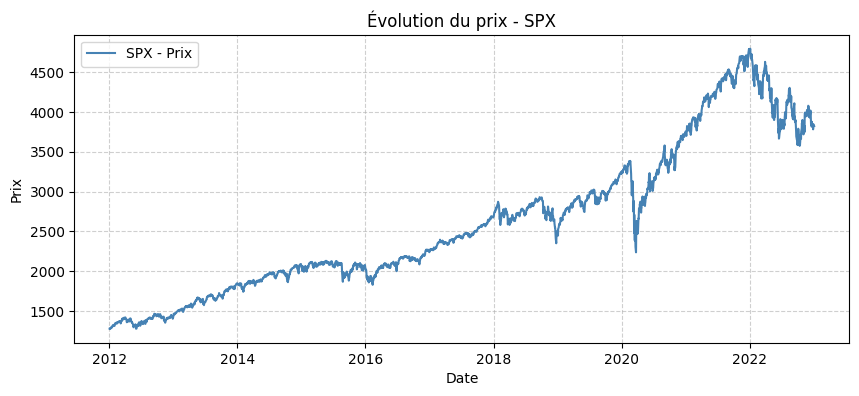

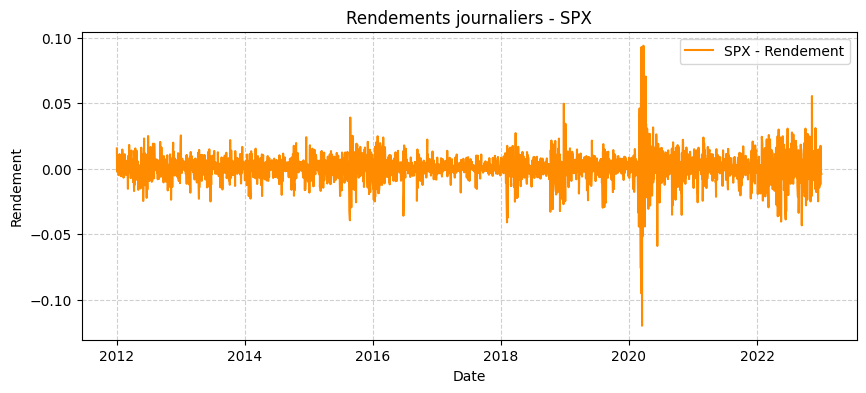

Analyse de LNC
Statistiques descriptives des rendements :
count      2769.0
mean     0.000629
std      0.027164
min     -0.331478
25%     -0.010658
50%      0.000964
75%      0.012797
max      0.317003
Name: ret, dtype: Float64


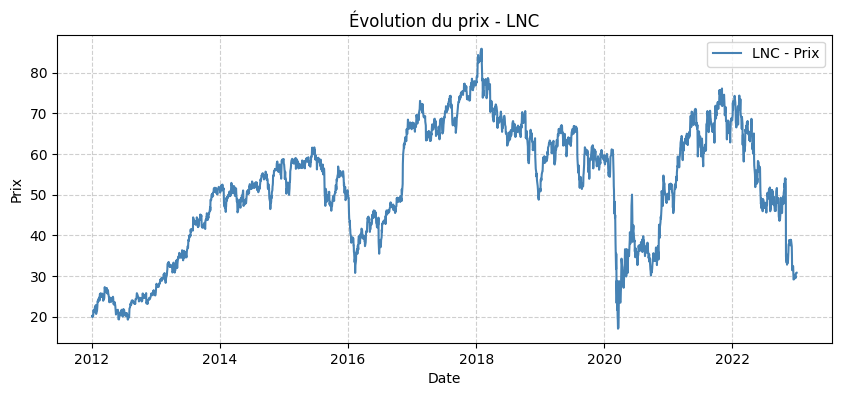

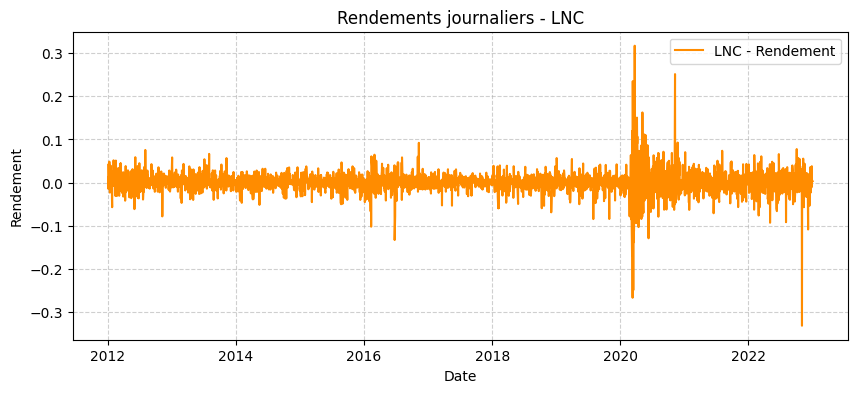

Analyse de LRCX
Statistiques descriptives des rendements :
count      2769.0
mean     0.001211
std      0.024158
min     -0.184277
25%     -0.010666
50%      0.001142
75%      0.013074
max      0.201919
Name: ret, dtype: Float64


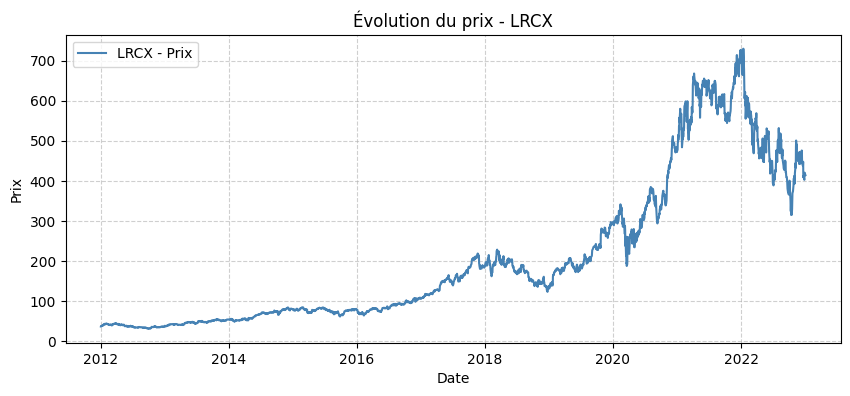

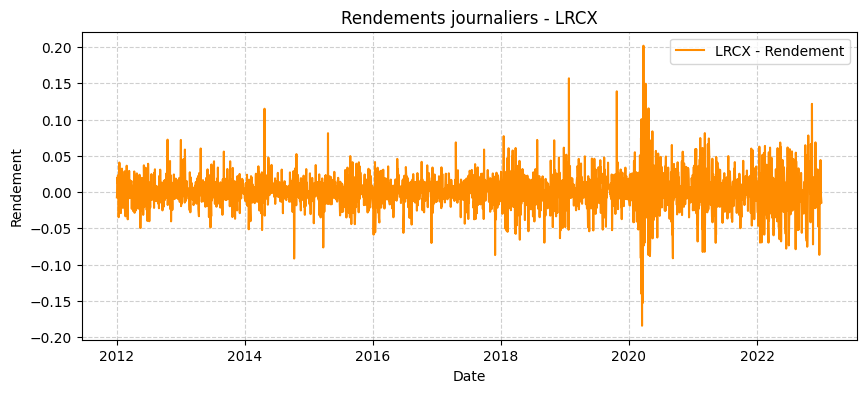

Analyse de LYB
Statistiques descriptives des rendements :
count      2769.0
mean     0.000788
std       0.02213
min      -0.25491
25%     -0.009726
50%      0.000619
75%       0.01149
max      0.195415
Name: ret, dtype: Float64


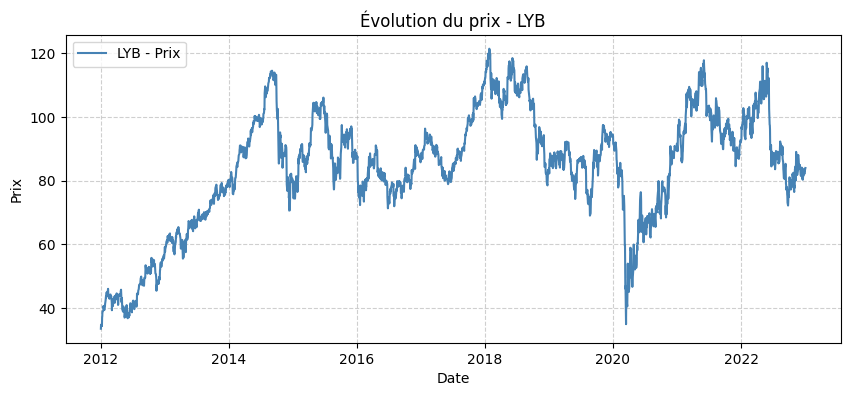

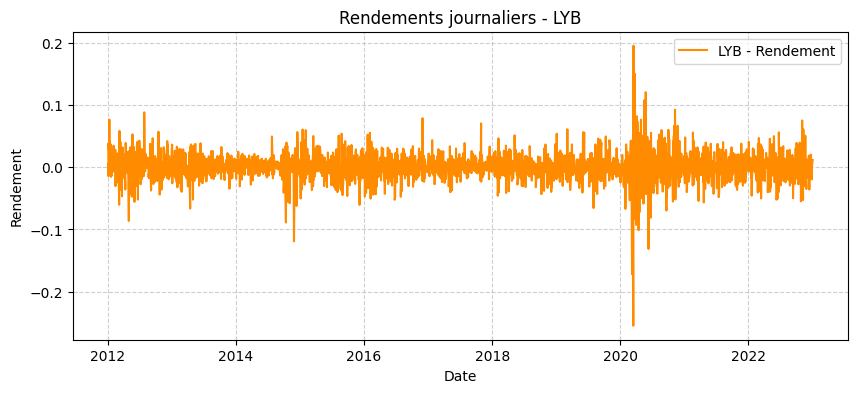

In [51]:
def analyze_title(name, df):
    print(f"Analyse de {name}")

    # données triées par date
    df = df.sort_values('date')

    # Statistiques descriptives
    print("Statistiques descriptives des rendements :")
    print(df['ret'].describe())

    # Série chronologique prix 
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['prc'], label=f'{name} - Prix', color='steelblue')
    plt.title(f"Évolution du prix - {name}")
    plt.xlabel('Date')
    plt.ylabel('Prix')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

    # Rendements 
    plt.figure(figsize=(10, 4))
    plt.plot(df['date'], df['ret'], label=f'{name} - Rendement', color='darkorange')
    plt.title(f"Rendements journaliers - {name}")
    plt.xlabel('Date')
    plt.ylabel('Rendement')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.show()

# analyse complète pour chaque titre
for name, df in titles_to_analyze.items():
    analyze_title(name, df)

## QUESTION b

In [52]:
# Quels titres on analyse - uniquement SPX et actions techno+énergie
titles_for_var = {
    'SPX': titles_to_analyze['SPX'],
    'LRCX': titles_to_analyze['LRCX'],
    'LYB': titles_to_analyze['LYB']  
}

In [53]:
def compute_var_es(df, name):
    returns = df['ret'].dropna()

    # Calcul quantiles empiriques 1%, 5%
    var_1 = returns.quantile(0.01)
    var_5 = returns.quantile(0.05)

    # ES : moyenne des pertes au-delà de la VaR
    es_1 = returns[returns <= var_1].mean()
    es_5 = returns[returns <= var_5].mean()

    # Affichage formaté
    print(f"Résultats de {name}")
    print(f"VaR à 1% : {var_1:.4%}")
    print(f"ES à 1% : {es_1:.4%}")
    print(f"VaR à 5% : {var_5:.4%}")
    print(f"ES à 5% : {es_5:.4%}")

for name, df in titles_for_var.items():
    compute_var_es(df, name)

Résultats de SPX
VaR à 1% : -3.1911%
ES à 1% : -4.5193%
VaR à 5% : -1.6283%
ES à 5% : -2.6453%
Résultats de LRCX
VaR à 1% : -6.7964%
ES à 1% : -8.6694%
VaR à 5% : -3.5592%
ES à 5% : -5.4781%
Résultats de LYB
VaR à 1% : -5.4353%
ES à 1% : -8.6986%
VaR à 5% : -3.2278%
ES à 5% : -5.0375%


## QUESTION c

In [60]:
def compute_parametric_var_es(df, name):
    returns = df['ret'].dropna()
    mu = returns.mean()
    sigma = returns.std()

    # Niveaux de confiance
    alpha_1 = 0.01
    alpha_5 = 0.05

    # VaR gaussienne
    var_1 = mu + sigma * norm.ppf(alpha_1)
    var_5 = mu + sigma * norm.ppf(alpha_5)

    # ES gaussienne
    es_1 = mu - sigma * norm.pdf(norm.ppf(alpha_1)) / alpha_1
    es_5 = mu - sigma * norm.pdf(norm.ppf(alpha_5)) / alpha_5

    print(f"Résultats paramétriques (Gaussienne) – {name}")
    print(f"VaR à 1% : {var_1:.4%}")
    print(f"ES à 1% : {es_1:.4%}")
    print(f"VaR à 5% : {var_5:.4%}")
    print(f"ES à 5% : {es_5:.4%}")

for name, df in titles_for_var.items():
    compute_parametric_var_es(df, name)

Résultats paramétriques (Gaussienne) – SPX
VaR à 1% : -2.4762%
ES à 1% : -2.8436%
VaR à 5% : -1.7373%
ES à 5% : -2.1904%
Résultats paramétriques (Gaussienne) – LRCX
VaR à 1% : -5.4989%
ES à 1% : -6.3175%
VaR à 5% : -3.8525%
ES à 5% : -4.8620%
Résultats paramétriques (Gaussienne) – LYB
VaR à 1% : -5.0695%
ES à 1% : -5.8194%
VaR à 5% : -3.5613%
ES à 5% : -4.4860%


## QUESTION d

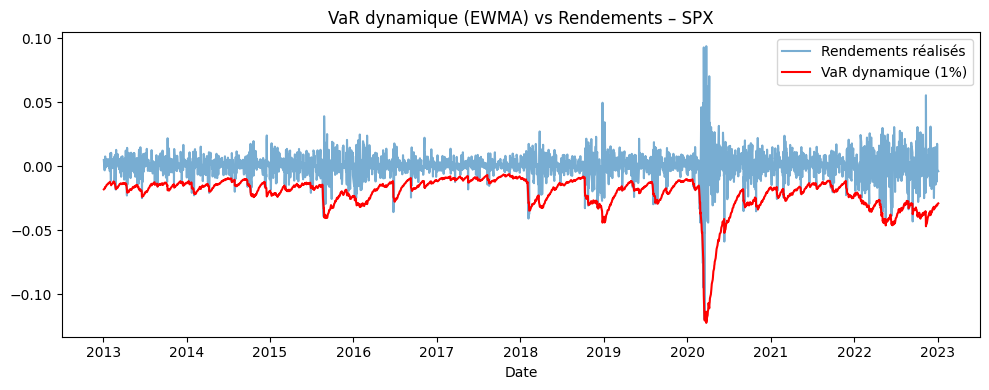

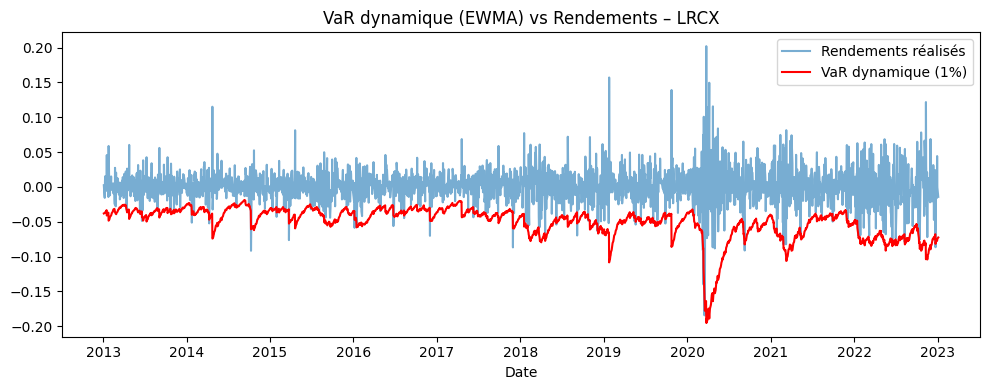

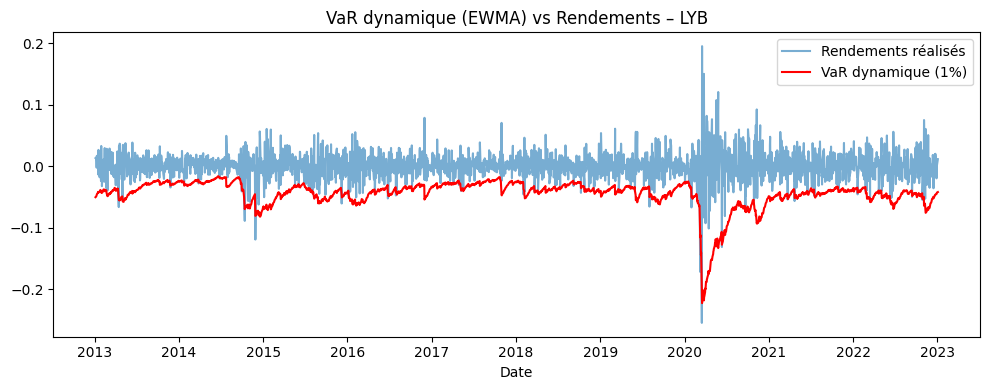

In [61]:
def compute_ewma_var(df, name, lambda_=0.94, alpha=0.01):
    returns = df['ret'].dropna().values
    dates = df['date'].iloc[-len(returns):].values

    # Initialiser avec la variance empirique sur la première année
    window = 252
    initial_var = np.var(returns[:window])
    ewma_var = [initial_var]

    for r in returns[window:]:
        new_var = lambda_ * ewma_var[-1] + (1 - lambda_) * r**2
        ewma_var.append(new_var)

    # Convertir variance en écart-type 
    sigma = np.sqrt(ewma_var)
    mu = np.mean(returns)

    # VaR dynamique non-paramétrique (quantile de la normale)
    z = np.percentile(np.random.randn(100000), alpha * 100)
    var_series = mu + z * sigma

    # Réaligner les dates et rendements réalisés
    realized_returns = returns[window:]
    dates_aligned = dates[window:]

    plt.figure(figsize=(10, 4))
    var_series = var_series[1:]
    plt.plot(dates_aligned, realized_returns, label='Rendements réalisés', alpha=0.6)
    plt.plot(dates_aligned, var_series, label='VaR dynamique (1%)', color='red')
    plt.title(f'VaR dynamique (EWMA) vs Rendements – {name}')
    plt.xlabel('Date')
    plt.legend()
    plt.tight_layout()
    plt.show()

for name, df in titles_for_var.items():
    compute_ewma_var(df, name)

## QUESTION e

In [70]:
# Création choc (7 jours)
def generate_shock(last_date):
    start_date = pd.to_datetime("2016-12-31")
    shock_dates = pd.bdate_range(start=start_date, periods=7)
    shock_returns = pd.Series([-0.11, -0.09, -0.08, -0.07, -0.05, -0.03, -0.02], index=shock_dates)
    shock_returns.index.name = 'date'
    return shock_returns

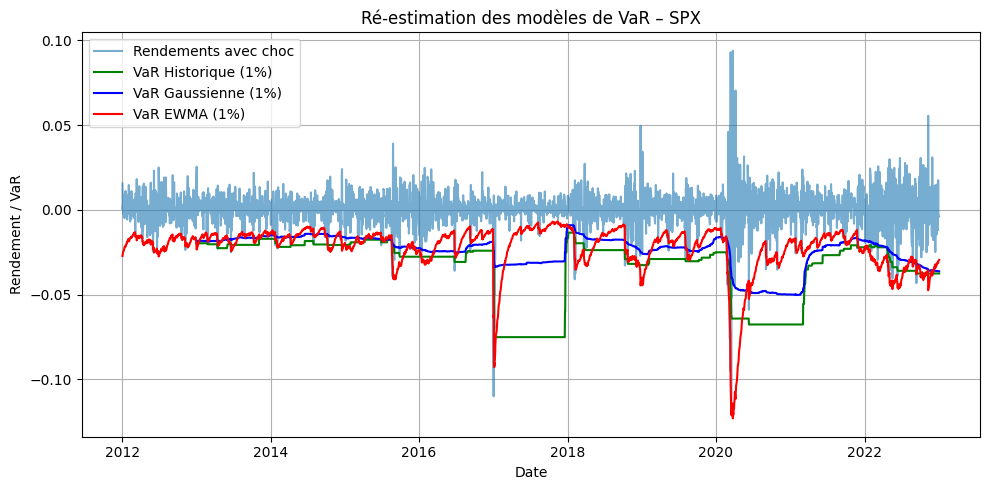

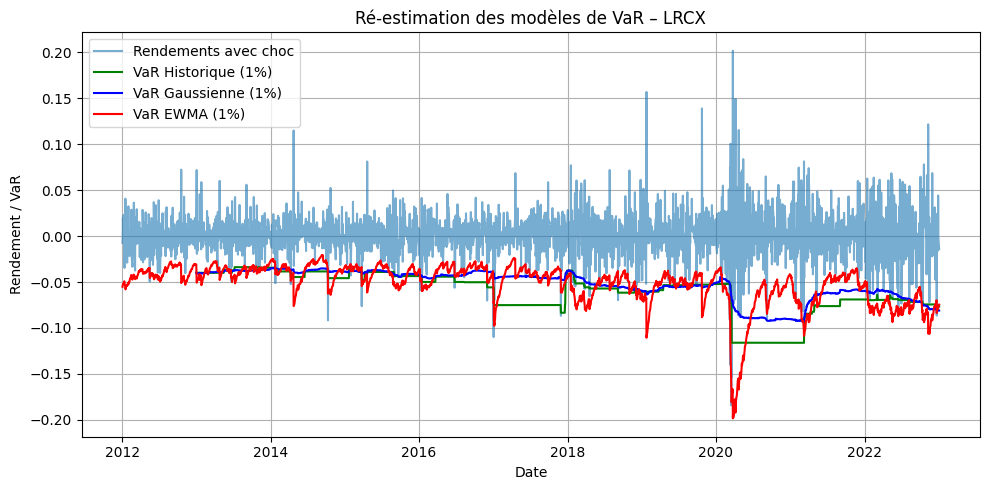

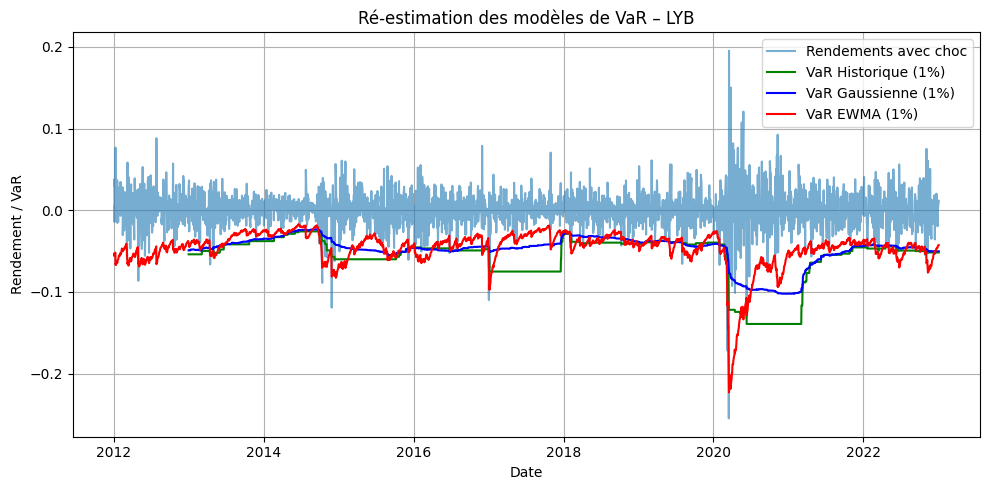

In [74]:
for name, df in titles_for_var.items():
    df = df.copy()
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
    else:
        df.index = pd.to_datetime(df.index)
    df.index.name = 'date'

    shock = generate_shock(df.index[-1])

    # Calcule retour historique avec choc
    full_returns = pd.concat([df['ret'], shock])
    full_returns.index = pd.to_datetime(full_returns.index)
    full_returns = full_returns.sort_index()

    # Recalcule VaR après choc
    var_hist = full_returns.rolling(250).apply(var_historique)
    var_gauss = var_gaussienne(full_returns, 250)
    var_ewma_series = var_ewma(full_returns)

    plt.figure(figsize=(10, 5))
    plt.plot(full_returns.index, full_returns, label="Rendements avec choc", alpha=0.6)
    plt.plot(var_hist.index, var_hist, label="VaR Historique (1%)", color="green")
    plt.plot(var_gauss.index, var_gauss, label="VaR Gaussienne (1%)", color="blue")
    plt.plot(var_ewma_series.index, var_ewma_series, label="VaR EWMA (1%)", color="red")
    plt.title(f"Ré-estimation des modèles de VaR – {name}")
    plt.xlabel("Date")
    plt.ylabel("Rendement / VaR")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## QUESTION f

In [83]:
def test_couverture(var_series, realized_returns, alpha=0.01):
    # Alignement des séries
    realized_returns, var_series = realized_returns.align(var_series, join='inner')

    # Violations : quand la perte est plus grande que la VaR (rappel: VaR < 0)
    violations = realized_returns < var_series

    T = len(var_series)
    nb_violations = violations.sum()

    # Statistique S du test de couverture
    S = (nb_violations - alpha * T) / ((alpha * (1 - alpha) * T) ** 0.5)

    return S, nb_violations, T

# Appliquer le test à chaque modèle
models = {
    'VaR Historique': var_hist,
    'VaR Gaussienne': var_gauss,
    'VaR EWMA': var_ewma_series
}

print("Test de couverture")
for name, var in models.items():
    S, nb_viol, T = test_couverture(var, df['ret'])
    print(f"{name} :")
    print(f" - Violations observées : {nb_viol} / {T}")
    print(f" - Statistique S = {S:.2f}")
    print()

Test de couverture
VaR Historique :
 - Violations observées : 32 / 2775
 - Statistique S = 0.81

VaR Gaussienne :
 - Violations observées : 48 / 2775
 - Statistique S = 3.86

VaR EWMA :
 - Violations observées : 29 / 2775
 - Statistique S = 0.24



## QUESTION g

In [93]:
def test_sequences(violations):
    # Retirer les valeurs manquantes
    violations = violations.dropna()

    # Convertit les booléens en int (1 = violation, 0 = pas violation)
    v = violations.astype(int).values

    # Nombre total de violations et non-violations
    n1 = v.sum()          # Violations
    n0 = len(v) - n1      # Non-violations

    # Nombre de séquences = transitions entre 0 et 1
    seq = 1 + np.sum(v[1:] != v[:-1])

    # Espérance et écart-type sous H0 (indépendance)
    expected = 1 + 2 * n0 * n1 / (n0 + n1)
    std = (2 * n0 * n1 * (2 * n0 * n1 - n0 - n1)) / ((n0 + n1)**2 * (n0 + n1 - 1))
    std = std**0.5

    Z = (seq - expected) / std

    return seq, expected, Z

# Application du test de séquences
print("Test de séquences")
for name, var in models.items():
    aligned_returns, aligned_var = df['ret'].align(var, join='inner')
    violations = aligned_returns < aligned_var
    runs_obs, runs_exp, Z = test_sequences(violations)

    print(f"{name} :")
    print(f" - Runs observés : {runs_obs}")
    print(f" - Runs attendus : {runs_exp:.2f}")
    print(f" - Statistique Z : {Z:.2f}")
    print()

Test de séquences
VaR Historique :
 - Runs observés : 57
 - Runs attendus : 64.19
 - Statistique Z : -5.76

VaR Gaussienne :
 - Runs observés : 83
 - Runs attendus : 95.18
 - Statistique Z : -6.53

VaR EWMA :
 - Runs observés : 59
 - Runs attendus : 58.39
 - Statistique Z : 0.56

